# Cvičení 07a: AE, VAE, GAN


## 1. Autoencoder

### Krok 1: příprava dat a normalizace

- **Dataset** Používáme \texttt{sklearn.datasets.load_digits} (číslice $8 \times 8$). Data jsou na vstupu jako plochý vektor o délce 64.
- **Normalizace**: Normalizace $\mathbf{X}=(X-\min(X))/(\max(X)-\min(X))$ zajistí, že hodnoty pixelů jsou v rozsahu $[0, 1]$. To je nutné, protože dekodér končí \texttt{nn.Sigmoid()}, které generuje výstup v tomto rozsahu.
- **DataLoader**: Vytvoří iterátor, který dodává data po dávkách (\texttt{batch_size=32}).

In [103]:
# Kód pro načtení, normalizaci a přípravu DataLoaderu (Slajd 8)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load Digits dataset
digits = load_digits()
X = digits['data']

# Normalizace na rozsah [0, 1]
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# DataLoader (pro input se nepoužívá label, proto jen data)
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Krok 2: Architektura Autoencoderu (nn.Module)

Autoencoder se skládá ze dvou symetrických částí: Encoderu a Decoderu.

Vysvětlení Architektury
- **Encoder**: Komprimuje vstup (64 prvků) do nižší, skryté reprezentace (latent_dim).
- **Decoder**: Rekonstruuje původní vstup (64 prvků) z komprimované latentní reprezentace.
- **Bottleneck**: Vrstva \texttt{latent_dim} nutí síť naučit se \textbf{klíčové informace} o datech (redukce dimenze).
- **Sigmoida**: Poslední vrstva dekodéru používá \texttt{nn.Sigmoid()}, aby udržela rekonstruované hodnoty mezi 0 a 1, v souladu se vstupní normalizací.

In [31]:
# Definice Autoencoderu
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder: 64 -> 32 -> latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
            nn.ReLU()
        )
        # Decoder: latent_dim -> 32 -> 64
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()  # Zajištění výstupu v rozsahu [0, 1]
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Inicializace: latentní dimenze 1
model = Autoencoder(1)
# Loss: Mean Squared Error (Minimalizace rozdílu mezi vstupem a výstupem) [cite: 39, 92]
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Krok 3: Trénovací smyčka a vizualizace

#### Vysvětlení tréninku

- **Cíl chyby**: Loss se počítá mezi output (rekonstrukce $\hat{x}$) a data (původní vstup $x$). Chceme, aby se $\hat{x}$ co nejvíce podobalo $x$.
- **Trénovací cyklus**: Používá standardní kroky PyTorch (nulování gradientů, zpětná propagace, aktualizace vah).

#### Visualizace rekonstrukce
- \texttt{torch.no_grad()}: Při testování/vykreslování vypínáme počítání gradientů (šetří paměť a čas)
- **Výsledek**: Horní řádek ukazuje původní vstupní číslice, dolní řádek \textbf{rekonstruované} číslice.

Epoch 1, Loss: 0.068922
Epoch 2, Loss: 0.047817
Epoch 3, Loss: 0.080186
Epoch 4, Loss: 0.040225
Epoch 5, Loss: 0.067645
Epoch 6, Loss: 0.048101
Epoch 7, Loss: 0.061021
Epoch 8, Loss: 0.045415
Epoch 9, Loss: 0.057597
Epoch 10, Loss: 0.060563
Epoch 11, Loss: 0.060343
Epoch 12, Loss: 0.047713
Epoch 13, Loss: 0.057017
Epoch 14, Loss: 0.050032
Epoch 15, Loss: 0.077785
Epoch 16, Loss: 0.068356
Epoch 17, Loss: 0.050462
Epoch 18, Loss: 0.043058
Epoch 19, Loss: 0.045488
Epoch 20, Loss: 0.048797
Epoch 21, Loss: 0.066930
Epoch 22, Loss: 0.055572
Epoch 23, Loss: 0.058820
Epoch 24, Loss: 0.040198
Epoch 25, Loss: 0.045050
Epoch 26, Loss: 0.054172
Epoch 27, Loss: 0.060277
Epoch 28, Loss: 0.055807
Epoch 29, Loss: 0.050888
Epoch 30, Loss: 0.050321
Epoch 31, Loss: 0.042121
Epoch 32, Loss: 0.061282
Epoch 33, Loss: 0.049662
Epoch 34, Loss: 0.048687
Epoch 35, Loss: 0.065803
Epoch 36, Loss: 0.052952
Epoch 37, Loss: 0.046466
Epoch 38, Loss: 0.047329
Epoch 39, Loss: 0.046720
Epoch 40, Loss: 0.054237
Epoch 41,

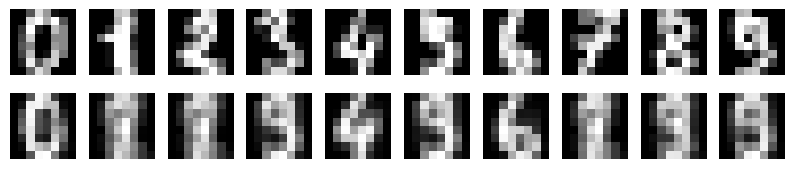

In [42]:
# Trénovací smyčka
for epoch in range(100):
    for i, (data,) in enumerate(dataloader):
        # Data je dvojice (data, data), ale DataLoader vrací jen (data,)
        output = model(data)
        loss = criterion(output, data) # Loss mezi rekonstrukcí a VSTUPEM
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    
# Vizualizace
with torch.no_grad():
    sample_data = torch.tensor(X[:10], dtype=torch.float32)
    reconstructed_data = model(sample_data).numpy()

fig, axs = plt.subplots(2, 10, figsize=(10, 2))

# Vykreslení
for i in range(10):
    # Původní data
    axs[0, i].imshow(X[i].reshape(8, 8), cmap='gray')
    axs[0, i].axis('off')
    # Rekonstruovaná data
    axs[1, i].imshow(reconstructed_data[i].reshape(8, 8), cmap='gray')
    axs[1, i].axis('off')

plt.show()

#### Úkoly pro studenty:
- Změňte latent_dim na 4, 8, 16 (původní: 64 $\rightarrow$ 1). Jak to ovlivní rekonstrukci?

## 2. Variational autoencoder

### Krok 1: Architektura VAE a latentní distribuce

VAE se liší od klasického AE v Kodéru. Kodér negeneruje jeden bod $\mathbf{z}$, ale parametry rozdělení ($\mu$ a $\log\sigma^2$).

#### Architektura
- **Encoder**: Končí vrstvou, která má velikost \texttt{latent_dim * 2}. Dělí se na vektor **středních hodnot** ($\mu$) a vektor **logaritmické variance** ($\log\sigma^2$).
- **Decoder**: Přijímá latentní vektor $\mathbf{z}$ (velikosti \texttt{latent_dim}) a snaží se rekonstruovat vstup.

#### Reparametrizační trik
Tento trik řeší problém, že náhodné vzorkování nelze derivovat, což by zablokovalo backpropagation do Kodéru.

**Vysvětlení reparametrizačního triku**
-- **Cíl:** Přenést náhodnost mimo síť, aby mohl gradient proudit.
-- **Postup:** Vzorek $\mathbf{z}$ se získá deterministicky z parametrů sítě ($\mu, \sigma$) a externího šumu ($\epsilon \sim \mathcal{N}(0, 1)$)4.
$$\mathbf{z} = \mu + \sigma \odot \epsilon$$

In [58]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # for mean and log variance
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h.split(h.size(1) // 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
    
model = VAE(8)

### Krok 2: Chybová funkce s KL divergencí
Chybová funkce VAE se skládá ze dvou členů:
1. **Rekonstrukční chyba** (\texttt{recon_loss}): Zajišťuje, že $\hat{x}$ je podobné $x$. Používá se binární Cross-Entropy (zde zjednodušená verze pro MSE/rozsah [0, 1]).
2. **Regularizační člen** (\texttt{kl_loss}): \textbf{KL divergence}. Měří, jak moc se naučená distribuce $q(\mathbf{z}|\mathbf{x})$ liší od standardní normální distribuce $\mathcal{N}(0, 1)$. Nutí kodér, aby byl latentní prostor plynulý a spojitý.

In [62]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = -torch.sum(x * torch.log(recon_x + 1e-9) + (1 - x) * torch.log(1 - recon_x + 1e-9))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

### Krok 3: Trénovací smyčka a vizualizace
- vesměs stejné jako u AE

In [70]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [78]:
for epoch in range(100):
    for i, (data,) in enumerate(dataloader):
        output, mu, log_var = model(data)
        loss = loss_function(output, data, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 120.55182647705078
Epoch 2, Loss: 120.09562683105469
Epoch 3, Loss: 140.3162384033203
Epoch 4, Loss: 128.4507598876953
Epoch 5, Loss: 122.24455261230469
Epoch 6, Loss: 117.5929183959961
Epoch 7, Loss: 115.53081512451172
Epoch 8, Loss: 131.23959350585938
Epoch 9, Loss: 112.94709777832031
Epoch 10, Loss: 116.1287841796875
Epoch 11, Loss: 122.45390319824219
Epoch 12, Loss: 123.5816879272461
Epoch 13, Loss: 122.08361053466797
Epoch 14, Loss: 115.7560043334961
Epoch 15, Loss: 131.30690002441406
Epoch 16, Loss: 130.33297729492188
Epoch 17, Loss: 132.1476287841797
Epoch 18, Loss: 117.75172424316406
Epoch 19, Loss: 130.4012908935547
Epoch 20, Loss: 128.58444213867188
Epoch 21, Loss: 133.71910095214844
Epoch 22, Loss: 117.97589874267578
Epoch 23, Loss: 103.83277893066406
Epoch 24, Loss: 124.86822509765625
Epoch 25, Loss: 120.41648864746094
Epoch 26, Loss: 125.86514282226562
Epoch 27, Loss: 125.64566802978516
Epoch 28, Loss: 119.51913452148438
Epoch 29, Loss: 132.17799377441406
Ep

### Krok 4: Test generativní schopnosti
Testujeme rekonstrukci a schopnost generovat varianty vstupních dat.

Standardní vizualizace rekonstrukce (původní vs. rekonstruovaný)
Pouze pro prvních 10 vzorků, bez počítání gradientů

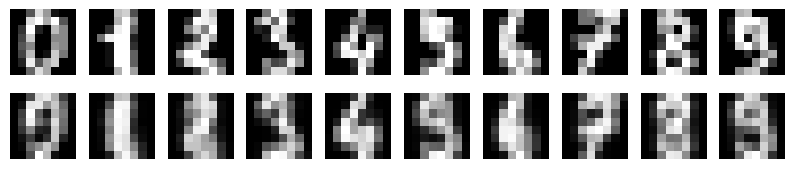

In [85]:
with torch.no_grad():
    sample_data = torch.tensor(X[:10], dtype=torch.float32)
    # Model vrací rekonstrukci, mu, a log_var. Zajímá nás jen rekonstrukce (první prvek).
    reconstructed_data, _, _ = model(sample_data)
    reconstructed_data = reconstructed_data.numpy()

fig, axs = plt.subplots(2, 10, figsize=(10, 2))

for i in range(10):
    axs[0, i].imshow(X[i].reshape(8, 8), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(reconstructed_data[i].reshape(8, 8), cmap='gray')
    axs[1, i].axis('off')

plt.show()

### Krok 5: Test generování variací (Sampling)
Získáme latentní distribuci prvního vzorku a 10x z ní vzorkujeme novou variantu.


Vizualizace generovaných variací (10 vzorků z distribuce prvního obrázku):


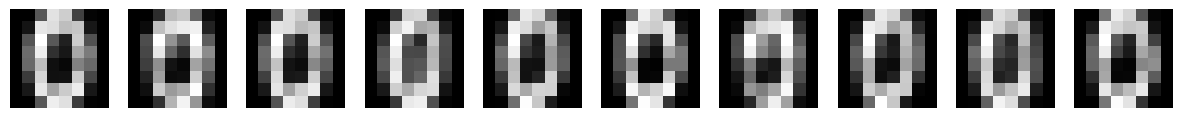

In [89]:
with torch.no_grad():
    # Získání distribuce pro první vzorek (index 0)
    h = model.encoder(torch.tensor(X[0:1], dtype=torch.float32))
    mu, logvar = h.split(h.size(1) // 2, dim=1)
    
    # Opakované vzorkování (10x) a dekódování pro generování variací
    # Model.reparameterize se zde volá přímo, protože jsme v kontextu modelu
    samples = [model.decoder(model.reparameterize(mu, logvar)).numpy().reshape(8, 8) for _ in range(10)]

fig, axs = plt.subplots(1, 10, figsize=(15, 1.5))

print("\nVizualizace generovaných variací (10 vzorků z distribuce prvního obrázku):")
for i, sample in enumerate(samples):
    axs[i].imshow(sample, cmap='gray')
    axs[i].axis('off')
    
plt.show()

## 3. GAN (nebo spíše CGAN (conditional GAN))

Cílem je implementovat Conditional GAN (CGAN), který se učí generovat číslice 0-9.

#### Krok 1: Příprava dat 
-- potřebujeme dodávat i třídu, proto nový DataLoader 

In [128]:
digits = load_digits()
X_np = digits['data'] # X jako NumPy pole
y_np = digits['target'] # Y jako NumPy pole

# Normalizace na rozsah [0, 1] pro Sigmoid na výstupu Generátoru
X_np = (X_np - np.min(X_np)) / (np.max(X_np) - np.min(X_np)) 

print(f"Data (X_np) načtena: {X_np.shape}, Labely (y_np) načteny: {y_np.shape}")

# Vytvoření DataLoaderu pro CGAN

# Tenzory: X musí být float, Y musí být long pro indexování (pro One-Hot)
gan_dataset = TensorDataset(
    torch.tensor(X_np, dtype=torch.float32), 
    torch.tensor(y_np, dtype=torch.long)
)

# DataLoader nyní vrací dvojice (data, labels)
dataloader = DataLoader(gan_dataset, batch_size=32, shuffle=True)

def one_hot_encode(y, n_classes=10):
    """Převede vektor labelů na One-Hot matici."""
    encoded = torch.zeros(y.size(0), n_classes, dtype=torch.float32)
    # y musí být Long Tensor pro indexování (protože y z DataLoaderu je Long)
    encoded[range(y.size(0)), y] = 1 
    return encoded

Data (X_np) načtena: (1797, 64), Labely (y_np) načteny: (1797,)


### Krok 2. Architektura modelů

In [131]:
# Generator (přijímá šum a label)
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Generator, self).__init__()
        # Vstup: latentní dim (10) + num_classes (10) = 20
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid() # Výstup v rozsahu [0, 1]
        )

    def forward(self, x, labels):
        # Spojení šumu a one-hot labelu
        x = torch.cat([x, labels], dim=1) 
        return self.model(x)

# Discriminator (přijímá data a label)
class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        # Vstup: data (64) + num_classes (10) = 74
        self.model = nn.Sequential(
            nn.Linear(64 + num_classes, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid() # Výstup: pravděpodobnost (0 až 1)
        )
        
    def forward(self, x, labels):
        # Spojení dat a one-hot labelu
        x = torch.cat([x, labels], dim=1)
        return self.model(x)
    
LATENT_DIM = 10
NUM_CLASSES = 10

generator = Generator(LATENT_DIM, NUM_CLASSES)
discriminator = Discriminator(NUM_CLASSES)

### Krok 3: Trénink

Trénink CGAN na 250 epoch.
Epoch   50, Loss D: 1.3072, Loss G: 0.7602


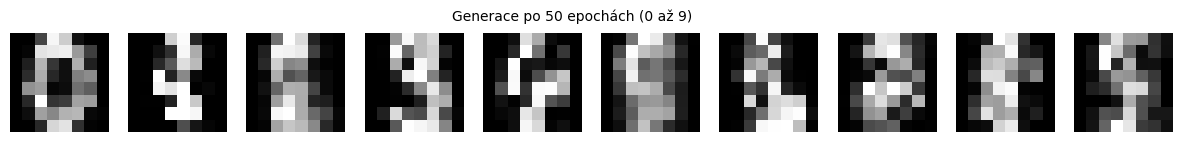

Epoch  100, Loss D: 1.3294, Loss G: 0.7120


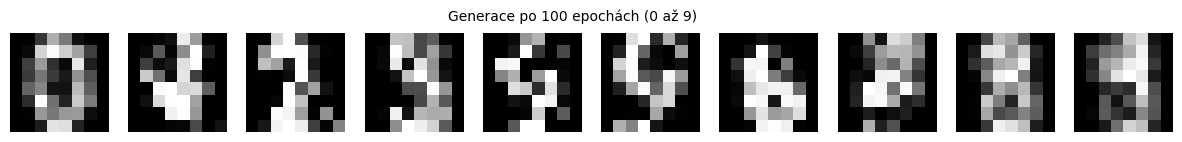

Epoch  150, Loss D: 1.2808, Loss G: 0.7998


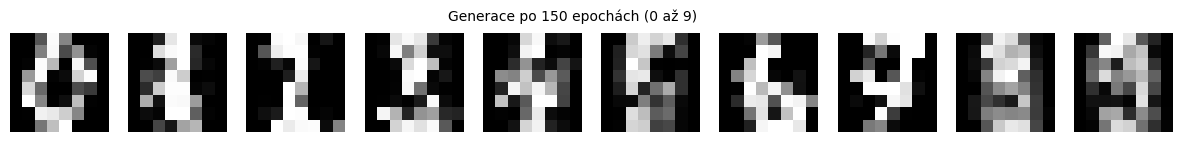

Epoch  200, Loss D: 1.5641, Loss G: 0.5962


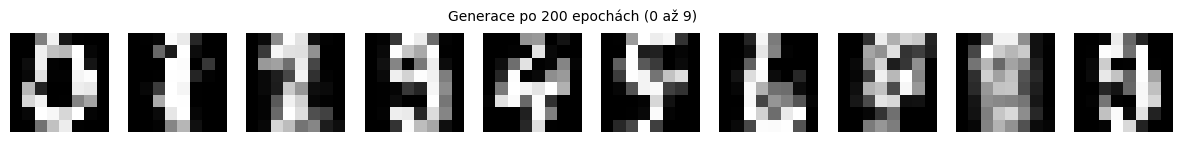

Epoch  250, Loss D: 1.4264, Loss G: 0.6734


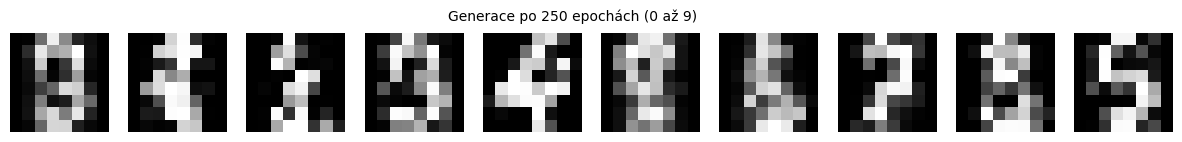

In [149]:
EPOCHS = 250

optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function (Binary Cross Entropy)
criterion = nn.BCELoss() 

print(f"Trénink CGAN na {EPOCHS} epoch.")

# --- 4. Trénovací Cyklus ---
for epoch in range(EPOCHS):
    for i, (real_data, real_labels) in enumerate(dataloader):
        # Dataloader vrací tensor labelů, který je torch.long, pro One-Hot ho použijeme
        real_labels_one_hot = one_hot_encode(real_labels)
        batch_size = real_data.shape[0]
        
        # Labely pro BCELoss
        label_real = torch.ones(batch_size, 1)
        label_fake = torch.zeros(batch_size, 1)
        
        # ---- Fáze 1: Trénink Diskriminátoru (Max D) ----
        optimizer_d.zero_grad()
        
        # 1. D na pravých datech (chceme 1)
        output_real = discriminator(real_data, real_labels_one_hot)
        loss_real = criterion(output_real, label_real)
        
        # Generování falešných dat
        noise = torch.randn(batch_size, LATENT_DIM)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,))
        fake_labels_one_hot = one_hot_encode(fake_labels)
        fake_data = generator(noise, fake_labels_one_hot)
        
        # 2. D na falešných datech (chceme 0)
        output_fake = discriminator(fake_data.detach(), fake_labels_one_hot) 
        loss_fake = criterion(output_fake, label_fake)
        
        loss_d = loss_real + loss_fake
        loss_d.backward()
        optimizer_d.step()
        
        # ---- Fáze 2: Trénink Generátoru (Min log(1-D(G(z))) ) ----
        optimizer_g.zero_grad()
        
        # G chce, aby D(Fake) -> 1
        output_fake = discriminator(fake_data, fake_labels_one_hot) 
        loss_g = criterion(output_fake, label_real) 
        
        loss_g.backward()
        optimizer_g.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:4}, Loss D: {loss_d.item():.4f}, Loss G: {loss_g.item():.4f}")
        
        with torch.no_grad():
            # Generujeme 10 vzorků (0 až 9)
            noise = torch.randn(10, LATENT_DIM)
            sample_labels = torch.tensor(list(range(10)))
            sample_labels_one_hot = one_hot_encode(sample_labels)
            generated_data = generator(noise, sample_labels_one_hot).numpy()
        
        fig, axs = plt.subplots(1, 10, figsize=(15, 1.5))
        fig.suptitle(f'Generace po {epoch+1} epochách (0 až 9)', fontsize=10)

        for i in range(10):
            axs[i].imshow(generated_data[i].reshape(8, 8), cmap='gray')
            axs[i].axis('off')

        plt.show()

# 4. Deep Convolutional Generative Adversarial Network (DCGAN)

Implementujeme a trénujeme DCGAN, který využívá konvoluční vrstvy (pro extrakci rysů v Diskriminátoru) a transponované konvoluční vrstvy (pro generování v Generátoru) k syntéze realistických obličejů.

In [161]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore") # Potlačení některých varování PyTorch

### Krok 1. Globální konfigurace

In [197]:
CUDA = True
# Používáme lokální složku pro stažení CIFAR-10
DATA_PATH = './data_cifar' 
OUT_PATH = './DCGAN_output' 

if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH)

BATCH_SIZE = 128
IMAGE_CHANNEL = 3 # RGB kanály
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64 # Rozměr obrázku (64x64)
D_HIDDEN = 64

EPOCH_NUM = 50
REAL_LABEL = 1.0
FAKE_LABEL = 0.0
lr = 2e-4
seed = 1

### Krok 2: Nastavení zařízení a seed

In [170]:
device = torch.device("cuda:0" if CUDA and torch.cuda.is_available() else "cpu")
print("Používáme zařízení: ", device)

np.random.seed(seed)
torch.manual_seed(seed)
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)
cudnn.benchmark = True

Používáme zařízení:  cuda:0


### Krok 3: Architektura modelů (Generator a Discriminator)

In [176]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 1. layer: Z_DIM -> G_HIDDEN*8 (4x4)
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False), 
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            
            # 2. layer: 4x4 -> 8x8
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            
            # 3. layer: 8x8 -> 16x16
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            
            # 4. layer: 16x16 -> 32x32
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            
            # 5. layer: 32x32 -> 64x64 (RGB)
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False), 
            nn.Tanh() 
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1. layer: 3x64x64 -> D_HIDDEN (32x32)
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 2. layer: 32x32 -> D_HIDDEN*2 (16x16)
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 3. layer: 16x16 -> D_HIDDEN*4 (8x8)
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 4. layer: 8x8 -> D_HIDDEN*8 (4x4)
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Output layer: 4x4 -> 1x1 (logit)
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() 
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1) 

def weights_init(m):
    """Inicializace vah pro Conv a BatchNorm vrstvy (dle DCGAN standardu)."""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 4. Inicializace modelů a datasetu

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr*.1, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

dataset = dset.CIFAR10(root=DATA_PATH, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(X_DIM), # Změna velikosti na 64x64 pro síť
                           transforms.ToTensor(),
                           # Normalizace na rozsah [-1, 1]
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
                       ]))
assert dataset
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

In [ ]:
# Vizualizační šum (konstantní pro sledování vývoje)
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

print(f"Trénink na {len(dataloader)} iterací na epochu.")

### Krok 5. Trénink DCGAN

In [203]:
for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader):
        # Data a labely (labely CIFAR-10 nepotřebujeme, jen obrázek)
        x_real = data[0].to(device)
        real_label = torch.full((x_real.size(0),), REAL_LABEL, device=device, dtype=torch.float)
        fake_label = torch.full((x_real.size(0),), FAKE_LABEL, device=device, dtype=torch.float)

        # 1. UPDATE DISKRIMINÁTORU (D)
        netD.zero_grad()
        
        # 1a. Pravá data
        y_real = netD(x_real)
        loss_D_real = criterion(y_real, real_label)
        loss_D_real.backward()

        # 1b. Falešná data
        z_noise = torch.randn(x_real.size(0), Z_DIM, 1, 1, device=device)
        x_fake = netG(z_noise)
        y_fake = netD(x_fake.detach()) # KLÍČOVÉ: .detach()
        loss_D_fake = criterion(y_fake, fake_label)
        loss_D_fake.backward()
        
        loss_D = loss_D_real + loss_D_fake
        optimizerD.step()

        # 2. UPDATE GENERÁTORU (G)
        netG.zero_grad()
        y_fake_r = netD(x_fake)
        loss_G = criterion(y_fake_r, real_label) # G chce, aby to bylo real (1)
        loss_G.backward()
        optimizerG.step()

        # --- VÝPISY A UKLÁDÁNÍ ---
        if i % 100 == 0:
            print('Epoch {} [{}/{}] Loss D: {:.4f} Loss G: {:.4f}'.format(
                epoch, i, len(dataloader),
                loss_D.mean().item(),
                loss_G.mean().item()
            ))

            # Ukládání vzorků pro vizualizaci
            with torch.no_grad():
                viz_sample = netG(viz_noise).detach().cpu()
                # Ukládání výsledku s vutils (které automaticky zvládá tensor -> image)
                vutils.save_image(viz_sample, 
                                  os.path.join(OUT_PATH, f'fake_samples_{epoch}_{i}.png'), 
                                  normalize=True)

Epoch 0 [0/391] Loss D: 0.1499 Loss G: 5.1005
Epoch 0 [100/391] Loss D: 0.4343 Loss G: 2.8978
Epoch 0 [200/391] Loss D: 0.6191 Loss G: 3.2181
Epoch 0 [300/391] Loss D: 0.5474 Loss G: 3.0029
Epoch 1 [0/391] Loss D: 0.0492 Loss G: 4.7122
Epoch 1 [100/391] Loss D: 0.4071 Loss G: 2.4891
Epoch 1 [200/391] Loss D: 0.5847 Loss G: 2.4870
Epoch 1 [300/391] Loss D: 0.1354 Loss G: 4.9869
Epoch 2 [0/391] Loss D: 0.4227 Loss G: 6.4964
Epoch 2 [100/391] Loss D: 0.5709 Loss G: 1.9849
Epoch 2 [200/391] Loss D: 0.0863 Loss G: 4.2045
Epoch 2 [300/391] Loss D: 0.0618 Loss G: 4.7204
Epoch 3 [0/391] Loss D: 0.7068 Loss G: 1.5809
Epoch 3 [100/391] Loss D: 0.3275 Loss G: 2.9278
Epoch 3 [200/391] Loss D: 0.5404 Loss G: 2.6679
Epoch 3 [300/391] Loss D: 0.4682 Loss G: 4.1425
Epoch 4 [0/391] Loss D: 0.4542 Loss G: 3.2275
Epoch 4 [100/391] Loss D: 0.0667 Loss G: 4.8763
Epoch 4 [200/391] Loss D: 0.4299 Loss G: 2.4194
Epoch 4 [300/391] Loss D: 2.3790 Loss G: 4.1890
Epoch 5 [0/391] Loss D: 0.3591 Loss G: 3.0451
Epoc

Načítám poslední generovaný obrázek: fake_samples_49_300.png


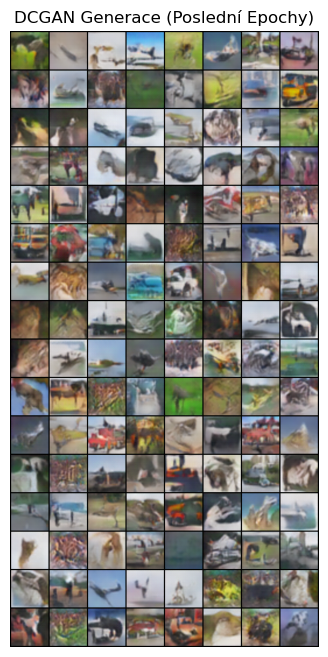

In [205]:
# %%
import os
from PIL import Image
import matplotlib.pyplot as plt

output_dir = OUT_PATH 

def get_latest_fake_sample(output_dir):
    """Najde soubor fake_samples_*.png s nejvyšším číslem epochy/iterace."""
    
    # Seznam všech souborů v adresáři
    files = os.listdir(output_dir)
    
    # Filtrování jen generovaných vzorků
    fake_files = [f for f in files if f.startswith('fake_samples_') and f.endswith('.png')]
    
    if not fake_files:
        return None

    # Získání čísla epochy a iterace pro každý soubor (pro nalezení nejnovějšího)
    # Název je ve formátu: fake_samples_EPOCH_ITERACE.png
    latest_file = max(fake_files, key=lambda f: tuple(map(int, f[len('fake_samples_'):-4].split('_'))))
    
    return os.path.join(output_dir, latest_file)

# --- Zobrazení ---

latest_image_path = get_latest_fake_sample(output_dir)

if latest_image_path:
    print(f"Načítám poslední generovaný obrázek: {os.path.basename(latest_image_path)}")
    
    # Načtení obrázku pomocí PIL (Python Imaging Library)
    img = Image.open(latest_image_path)
    
    # Zobrazení v Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"DCGAN Generace (Poslední Epochy)")
    plt.axis('off')
    plt.show()
else:
    print("Nebyl nalezen žádný soubor s generovanými vzorky v cílové složce.")